In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [ ]:
!wget https://github.com/MartinCastroMorales-mcm/entornoRL/raw/refs/heads/master/game_data.csv

--2025-12-28 23:30:05--  https://github.com/MartinCastroMorales-mcm/entornoRL/raw/refs/heads/master/game_data.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MartinCastroMorales-mcm/entornoRL/refs/heads/master/game_data.csv [following]
--2025-12-28 23:30:05--  https://raw.githubusercontent.com/MartinCastroMorales-mcm/entornoRL/refs/heads/master/game_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5390847 (5.1M) [text/plain]
Saving to: ‘game_data.csv’

game_data.csv       100%[===================>]   5.14M  --.-KB/s    in 0.05s   

2025-12-28 23:30:05 (107 MB/s) - ‘game_data.csv’ sav

In [ ]:
df = pd.read_csv('/content/game_data.csv',
                 engine="python",
                  on_bad_lines="warn")

In [ ]:
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])

Rows: 3236
Columns: 778


In [ ]:
for i, col in enumerate(df.columns):
    print(i, repr(col))

0 'frame'
1 'score'
2 'lives'
3 'power'
4 'polarity'
5 'player_x'
6 'player_y'
7 'chain_count'
8 'chain_color'
9 'input_up'
10 'input_down'
11 'input_left'
12 'input_right'
13 'input_fire'
14 'input_polarity'
15 'enemy_count'
16 'bullet_count'
17 'reward'
18 'e_0_x'
19 'e_0_y'
20 'e_0_type'
21 'e_0_pol'
22 'e_0_vx'
23 'e_0_vy'
24 'e_0_ax'
25 'e_0_ay'
26 'e_1_x'
27 'e_1_y'
28 'e_1_type'
29 'e_1_pol'
30 'e_1_vx'
31 'e_1_vy'
32 'e_1_ax'
33 'e_1_ay'
34 'e_2_x'
35 'e_2_y'
36 'e_2_type'
37 'e_2_pol'
38 'e_2_vx'
39 'e_2_vy'
40 'e_2_ax'
41 'e_2_ay'
42 'e_3_x'
43 'e_3_y'
44 'e_3_type'
45 'e_3_pol'
46 'e_3_vx'
47 'e_3_vy'
48 'e_3_ax'
49 'e_3_ay'
50 'e_4_x'
51 'e_4_y'
52 'e_4_type'
53 'e_4_pol'
54 'e_4_vx'
55 'e_4_vy'
56 'e_4_ax'
57 'e_4_ay'
58 'e_5_x'
59 'e_5_y'
60 'e_5_type'
61 'e_5_pol'
62 'e_5_vx'
63 'e_5_vy'
64 'e_5_ax'
65 'e_5_ay'
66 'e_6_x'
67 'e_6_y'
68 'e_6_type'
69 'e_6_pol'
70 'e_6_vx'
71 'e_6_vy'
72 'e_6_ax'
73 'e_6_ay'
74 'e_7_x'
75 'e_7_y'
76 'e_7_type'
77 'e_7_pol'
78 'e_7_vx'
79 '

In [ ]:
with open("game_data.csv") as f:
    lengths = [len(line.rstrip("\n").split(",")) for line in f]

pd.Series(lengths).describe()

,0
count,3237.0
mean,778.0
std,0.0
min,778.0
25%,778.0
50%,778.0
75%,778.0
max,778.0


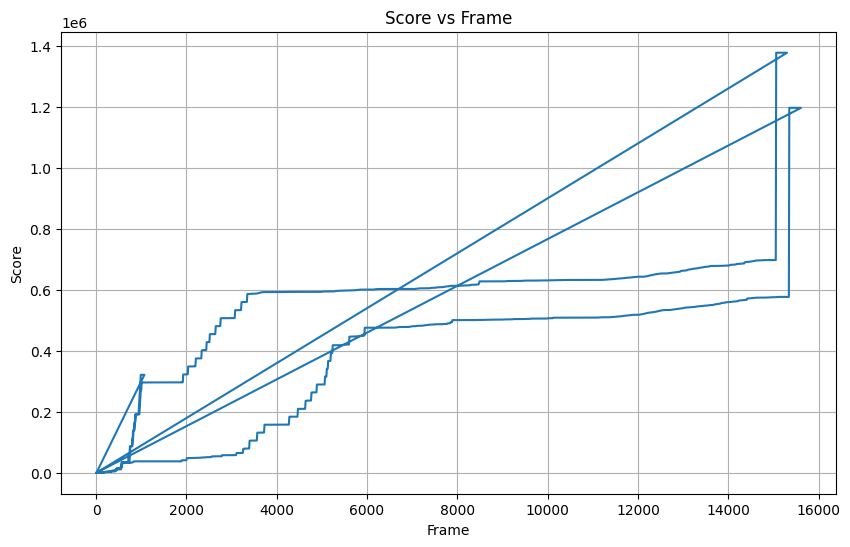

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['frame'], df['score']) # Changed to plt.plot for a line graph
plt.xlabel('Frame')
plt.ylabel('Score')
plt.title('Score vs Frame')
plt.grid(True)
plt.show()

## Preprocesar

In [ ]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [ ]:
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df_train, df_tmp = train_test_split(
    df_normalized,
    test_size=0.2,
    random_state=42
)
df_val, df_test = train_test_split(
    df_tmp,
    test_size=0.5,  # half of temp -> test, half -> val
    random_state=42
)


In [ ]:
df_train.columns

Index(['frame', 'score', 'lives', 'power', 'polarity', 'player_x', 'player_y',
       'chain_count', 'chain_color', 'input_up',
       ...
       'b_98_type', 'b_98_pol', 'b_98_ang', 'b_98_amp', 'b_99_x', 'b_99_y',
       'b_99_type', 'b_99_pol', 'b_99_ang', 'b_99_amp'],
      dtype='object', length=778)

### Get formal state (no input, no reward, no score)

In [ ]:
def placeholdername(df) -> tuple[pd.DataFrame, pd.DataFrame]:
  global_state_df = df.loc[:, : "chain_color"]
  specific_state = df.loc[:, "e_0_x" :]
  y = df.loc[:, "input_up":"input_polarity"]
  X = pd.concat([global_state_df, specific_state], axis=1)
  print(global_state_df.shape)
  print(specific_state.shape)
  print(X.shape)
  #X = df.drop(columns=y.columns)

  assert len(X) == len(y)
  assert X.shape[1] == 769
  return (X, y)

In [ ]:
X_train, y_train = placeholdername(df_train)
X_test, y_test = placeholdername(df_test)
X_val, y_test = placeholdername(df_val)

(2588, 9)
(2588, 760)
(2588, 769)
(324, 9)
(324, 760)
(324, 769)
(324, 9)
(324, 760)
(324, 769)


In [ ]:
X_train

,frame,score,lives,power,polarity,player_x,player_y,chain_count,chain_color,e_0_x,...,b_98_type,b_98_pol,b_98_ang,b_98_amp,b_99_x,b_99_y,b_99_type,b_99_pol,b_99_ang,b_99_amp
2933,0.830769,0.391438,0.75,0.050000,0.0,0.418919,0.666667,0.000000,0.0,0.499115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1803,0.106410,0.027082,1.00,0.641667,1.0,0.699324,0.653846,0.666667,0.5,0.498272,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1272,0.746795,0.463029,0.50,0.383333,0.0,0.412162,0.786325,0.333333,0.5,0.499115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
761,0.419231,0.437529,0.75,0.000000,0.0,0.682432,0.837607,1.000000,1.0,0.500084,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2830,0.764744,0.376016,0.75,0.291667,0.0,0.513514,0.735043,0.000000,0.0,0.498272,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,0.633333,0.457728,0.50,0.133333,1.0,0.459459,0.777778,0.666667,1.0,0.505520,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1130,0.655769,0.458643,0.50,0.191667,1.0,0.567568,0.735043,0.666667,0.5,0.505436,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1294,0.760897,0.465497,0.50,0.541667,0.0,0.317568,0.606838,0.333333,0.5,0.499115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,0.482692,0.440913,0.75,0.166667,1.0,0.594595,0.393162,0.666667,1.0,0.504762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_train

,input_up,input_down,input_left,input_right,input_fire,input_polarity
2933,0.0,0.0,0.0,0.0,1.0,0.0
1803,0.0,0.0,0.0,0.0,0.0,0.0
1272,0.0,0.0,0.0,0.0,1.0,0.0
761,0.0,0.0,1.0,0.0,0.0,0.0
2830,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...
1095,0.0,0.0,0.0,0.0,0.0,0.0
1130,0.0,0.0,0.0,1.0,1.0,0.0
1294,0.0,1.0,0.0,0.0,1.0,0.0
860,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
action_counts = y_train.sum(axis=0)
print(action_counts)

input_up           186.0
input_down         175.0
input_left         313.0
input_right        348.0
input_fire        1375.0
input_polarity      61.0
dtype: float64


In [ ]:
class SimpleDataset(Dataset):
    def __init__(self, X_df, y_df):
        self.X = torch.tensor(X_df.values, dtype=torch.float32)
        self.y = torch.tensor(y_df.values, dtype=torch.float32)


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
from torch.utils.data import DataLoader

train_ds = SimpleDataset(X_train, y_train)
test_ds  = SimpleDataset(X_test, y_test)
val_ds  = SimpleDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)
val_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)


In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(769, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
    )
  def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork()

In [ ]:
pos_weight = torch.tensor([1.0, 1.0, 1.0, 1.0, 0.1, 1.0])

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
from sklearn.metrics import hamming_loss

In [ ]:
def validate_multilabel_hamming(model, dataloader, loss_fn, device='cpu', threshold=0.5):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    hamming_scores = []
    accuracy_scores = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device).float()
            y_batch = y_batch.to(device).float()

            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

            preds = (torch.sigmoid(outputs) > threshold).float()

            batch_score = 1 - hamming_loss(y_batch.cpu().numpy(), preds.cpu().numpy())
            hamming_scores.append(batch_score)


            correct += (preds == y_batch).float().sum().item()
            total += y_batch.numel()
            accuracy = correct / total
            accuracy_scores.append(accuracy)


    avg_acuracy = sum(accuracy_scores) / len(accuracy_scores)
    avg_loss = val_loss / len(dataloader.dataset)
    avg_hamming = sum(hamming_scores) / len(hamming_scores)
    return avg_loss, avg_hamming, avg_acuracy

In [ ]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    val_loss, avg_hamming_score, avg_accuracy = validate_multilabel_hamming(model, test_loader, loss_fn)
    print(f"avg_hamming_score: {avg_hamming_score}")
    print(f"val_loss: {val_loss}")
    print(f"avg_accuracy: {avg_accuracy}")
print("Done!")

Epoch 1
-------------------------------
loss: 0.702584  [   64/ 2588]
avg_hamming_score: 0.3389756944444445
val_loss: 0.7037445770369636
avg_accuracy: 0.3310190543552812
Epoch 2
-------------------------------
loss: 0.704663  [   64/ 2588]
avg_hamming_score: 0.3446180555555556
val_loss: 0.7034287254015604
avg_accuracy: 0.3374576688957476
Epoch 3
-------------------------------
loss: 0.701971  [   64/ 2588]
avg_hamming_score: 0.3541666666666667
val_loss: 0.7031136670230348
avg_accuracy: 0.3491383744855967
Epoch 4
-------------------------------
loss: 0.704102  [   64/ 2588]
avg_hamming_score: 0.3602430555555556
val_loss: 0.7027987469861536
avg_accuracy: 0.357413301611797
Epoch 5
-------------------------------
loss: 0.701541  [   64/ 2588]
avg_hamming_score: 0.3680555555555556
val_loss: 0.7024842861257954
avg_accuracy: 0.3675357938957476
Epoch 6
-------------------------------
loss: 0.703306  [   64/ 2588]
avg_hamming_score: 0.38237847222222227
val_loss: 0.7021710548871829
avg_accuracy:

In [ ]:
avg_loss, avg_hamming, avg_accuracy = validate_multilabel_hamming(model ,val_loader, loss_fn)

In [ ]:
print(avg_loss)
print(avg_accuracy)

0.6887921668865062
0.5672156314300412


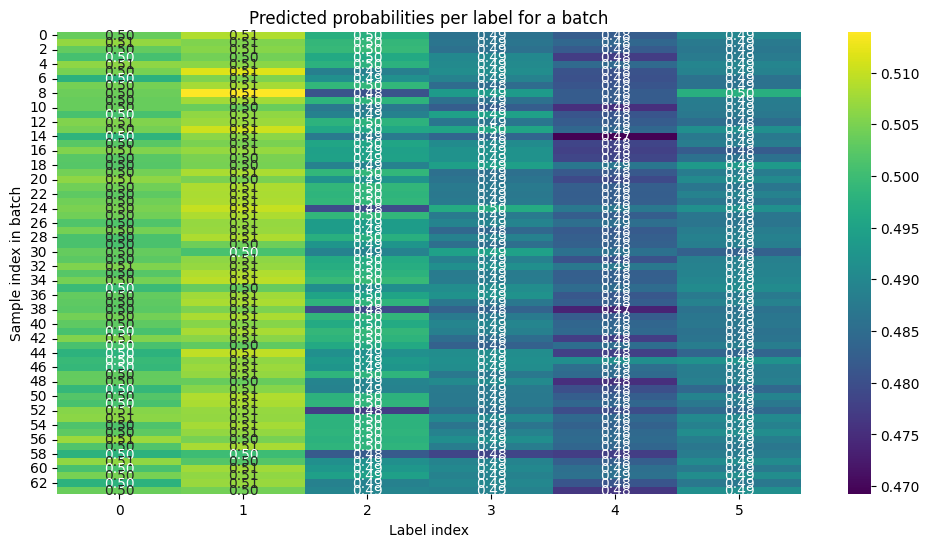

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Put your model in eval mode
model.eval()

# Take a batch from your dataloader
X_batch, y_batch = next(iter(val_loader))  # or train_loader

# Forward pass (get logits)
with torch.no_grad():
    outputs = model(X_batch)  # shape [batch_size, num_labels]
    probs = torch.sigmoid(outputs)  # convert logits to probabilities

# Convert to numpy for plotting
probs_np = probs.numpy()  # shape [batch_size, num_labels]

# Plot as heatmap
plt.figure(figsize=(12,6))
sns.heatmap(probs_np, annot=True, fmt=".2f", cmap="viridis")
plt.xlabel("Label index")
plt.ylabel("Sample index in batch")
plt.title("Predicted probabilities per label for a batch")
plt.show()

In [ ]:
probs_np

array([[0.50364256, 0.5085585 , 0.49744758, 0.48618558, 0.4823122 ,
        0.48972595],
       [0.5067749 , 0.505353  , 0.49885002, 0.48659998, 0.48393685,
        0.4875135 ],
       [0.5031432 , 0.50591123, 0.49923062, 0.48567536, 0.48196542,
        0.48691955],
       [0.5007639 , 0.50441843, 0.49628413, 0.49019793, 0.47712958,
        0.48761463],
       [0.5064161 , 0.5060941 , 0.4978357 , 0.49042434, 0.4845337 ,
        0.48968634],
       [0.50486314, 0.51179093, 0.48833466, 0.491042  , 0.48075685,
        0.48906305],
       [0.497842  , 0.5053389 , 0.49147746, 0.48904952, 0.4803076 ,
        0.486125  ],
       [0.5045223 , 0.5079006 , 0.4986165 , 0.48487017, 0.48101857,
        0.48608062],
       [0.5039497 , 0.5139435 , 0.48066127, 0.49358538, 0.4821105 ,
        0.49744117],
       [0.5036365 , 0.5077945 , 0.49815077, 0.48572856, 0.48217613,
        0.48786715],
       [0.5035254 , 0.5037526 , 0.48721424, 0.48244372, 0.4752882 ,
        0.48775843],
       [0.5008568 , 0

In [ ]:
# Put your model in eval mode
model.eval()



NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=769, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=6, bias=True)
  )
)

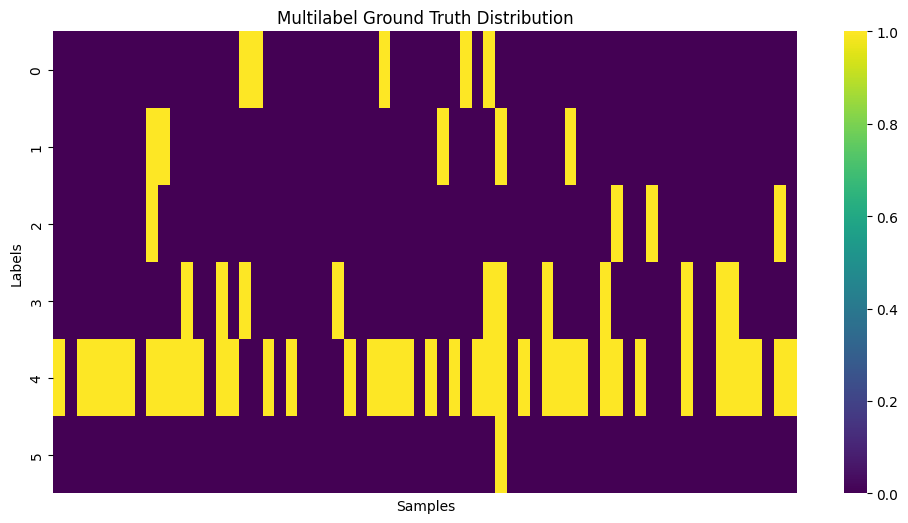

In [ ]:
# Take a batch from your dataloader
X_batch, y_batch = next(iter(val_loader))  # or train_loader

plt.figure(figsize=(12, 6))
sns.heatmap(y_batch.T, cmap="viridis", cbar=True, xticklabels=False, yticklabels=True)
plt.xlabel("Samples")
plt.ylabel("Labels")
plt.title("Multilabel Ground Truth Distribution")
plt.show()

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

# Experimento dentro del entorno de gymnasium con el modelo previamente entrenado

In [ ]:
!wget https://github.com/MartinCastroMorales-mcm/entornoRL/raw/refs/heads/master/run_bc.csv

In [ ]:
run_bc_df = pd.read_csv('/content/run_bc.csv',
                 engine="python",
                  on_bad_lines="warn")

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(run_bc_df['frame'], run_bc_df['score']) # Changed to plt.plot for a line graph
plt.xlabel('Frame')
plt.ylabel('Score')
plt.title('Score vs Frame')
plt.grid(True)
plt.show()

## Observacion

El modelo de behavioral cloning no funciona correctamente, no logra finalizar el juego o conseguir una puntuacion alta. Es posible que con una mayor cantidad de datos se pueda entrenar de forma efectiva ya que se han realizado modelos de mayor complejidad con este metodo como lo puede ser:

Counter-Strike Deathmatch with Large-Scale Behavioural Cloning

arXiv:2104.04258

In [ ]:
run_bc_df = pd.read_csv('/content/grafico_runs.csv',
                 engine="python",
                  on_bad_lines="warn")

In [ ]:
run_bc_df.head()

,frame,random,model_0,bc,bc2,Run_20_000,Run_50_000
0,10,0.0,0.0,0.0,0,0.0,0.0
1,20,0.0,0.0,0.0,0,0.0,0.0
2,30,0.0,0.0,0.0,0,0.0,0.0
3,40,0.0,0.0,0.0,0,0.0,0.0
4,50,0.0,0.0,0.0,0,0.0,0.0


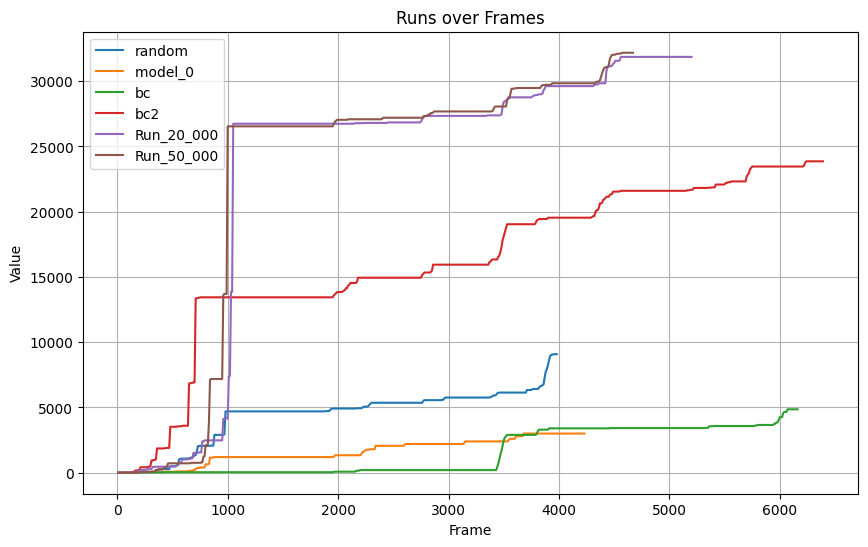

In [ ]:
plt.figure(figsize=(10, 6))

# Plot each run column
for col in run_bc_df.columns:
    if col != "frame":
        plt.plot(run_bc_df["frame"], run_bc_df[col], label=col)

# Labels and title
plt.xlabel("Frame")
plt.ylabel("Value")
plt.title("Runs over Frames")
plt.legend()
plt.grid(True)
plt.show()